## Importing Libraries and Helper Functions

In [23]:
# Ignore Warning
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Import the necessary packages
import os, sys
import torch
import torchvision
import time
import cv2

# Add the module path to the sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [25]:
# Import local helper files
from utils.dataset import load

## Check for GPU Availability

In [26]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available CUDA devices: {num_gpus}")
    
    # Print the name of each GPU
    for i in range(num_gpus):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

# Set the device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Number of available CUDA devices: 1
Device 0: NVIDIA GeForce RTX 3060 Ti


## Define the Variables

In [27]:
# Specify the shape of the inputs for our network
IMG_SIZE = 120
CROP_SIZE = 110
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [28]:
# Specify the batch size, number of epochs, and the size of the chunks
BATCH_SIZE = 32
NUM_EPOCHS = 2
CHUNK_SIZE = 10000

# Predefined Functions

### Function Parameters and Returns Description

#### `FurniturePairDataset`
**Parameters**:
- `df` (DataFrame): DataFrame containing image file paths.
- `root_dir` (str): Root directory where the images are stored.
- `transform` (callable, optional): A function/transform that takes in a PIL image and returns a transformed version.

**Returns**:
- `__len__()`:
  - Returns (int): The total number of pairs (twice the number of images).
- `__getitem__(idx)`:
  - Returns (tuple): A tuple containing a pair of images and a label (1 for similar, 0 for dissimilar).

#### `get_output_shape`
**Parameters**:
- `model` (nn.Module): The neural network model whose output shape is to be determined.
- `image_dim` (tuple): The dimensions of the input image (height, width).
- `device` (torch.device): The device (CPU or GPU) on which the model and dummy input will be loaded.

**Returns**:
- Returns (int): The shape of the output tensor after passing the dummy input through the model.

In [29]:
# Pair Dataset
class FurniturePairDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.data_df = df
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.color_histograms = []
        self.edge_histograms = []
        self._load_images_and_features()

    def _load_images_and_features(self):
        for idx in range(len(self.data_df)):
            try: 
                img_name = os.path.join(self.root_dir, self.data_df.iloc[idx, 0])
                image = Image.open(img_name)
                self.images.append(image)
                self.color_histograms.append(self._extract_color_histogram(image))
                self.edge_histograms.append(self._extract_edge_histogram(image))
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")

    def _extract_color_histogram(self, image):
        image = np.array(image.convert("RGB"))
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        return hist.flatten()

    def _extract_edge_histogram(self, image):
        image = np.array(image.convert("L"))
        edges = cv2.Canny(image, 100, 200)
        hist = cv2.calcHist([edges], [0], None, [256], [0, 256])
        cv2.normalize(hist, hist)
        return hist.flatten()

    def __len__(self):
        return len(self.data_df) * 2  # Each image will appear in one positive and one negative pair

    def __getitem__(self, idx):
        anchor_idx = idx // 2
        anchor_image = self.images[anchor_idx]
        anchor_color_hist = self.color_histograms[anchor_idx]
        anchor_edge_hist = self.edge_histograms[anchor_idx]

        if self.transform:
            anchor_image = self.transform(anchor_image)

        if idx % 2 == 0:
            similar_idx = self._find_most_similar(anchor_idx, anchor_color_hist)
            similar_image = self.images[similar_idx]

            if self.transform:
                similar_image = self.transform(similar_image)

            return (anchor_image, similar_image), 1
        else:
            dissimilar_idx = self._find_most_dissimilar(anchor_idx, anchor_edge_hist)
            dissimilar_image = self.images[dissimilar_idx]

            if self.transform:
                dissimilar_image = self.transform(dissimilar_image)

            return (anchor_image, dissimilar_image), 0

    def _find_most_similar(self, anchor_idx, anchor_hist):
        max_similarity = -1
        similar_idx = -1
        for idx in range(len(self.data_df)):
            if idx == anchor_idx:
                continue
            hist = self.color_histograms[idx]
            similarity = cv2.compareHist(anchor_hist, hist, cv2.HISTCMP_CORREL)
            if similarity > max_similarity:
                max_similarity = similarity
                similar_idx = idx
        return similar_idx

    def _find_most_dissimilar(self, anchor_idx, anchor_hist):
        min_similarity = 1
        dissimilar_idx = -1
        for idx in range(len(self.data_df)):
            if idx == anchor_idx:
                continue
            hist = self.edge_histograms[idx]
            similarity = cv2.compareHist(anchor_hist, hist, cv2.HISTCMP_CORREL)
            if similarity < min_similarity:
                min_similarity = similarity
                dissimilar_idx = idx
        return dissimilar_idx
    
# Get the Output Dimension of VGG16    
def get_output_shape(model, image_dim, device):
    model = model.to(device)  # Ensure the model is on the same device as the dummy input
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, *image_dim).to(device)
        output = model(dummy_input)
    return output.shape[1]

# Load Dataset

In [30]:
# Path to the dataset
dataPath = '../../Data/Processed_Data/'

In [31]:
# Load DataFrame
furniture_dataset = load(dataPath)

In [32]:
# Check the shape of the dataset
furniture_dataset

,ImgPath,FileType,Width,Height,Ratio,Mode,Bands,Transparency,Animated,Category,Interior_Style
0,beds\Asian\19726asian-daybeds.jpg,jpg,350,350,1.0,RGB,R G B,False,False,beds,Asian
1,beds\Asian\20027asian-canopy-beds.jpg,jpg,350,350,1.0,RGB,R G B,False,False,beds,Asian
2,beds\Asian\20109asian-panel-beds.jpg,jpg,350,350,1.0,RGB,R G B,False,False,beds,Asian
3,beds\Asian\20508asian-platform-beds.jpg,jpg,350,350,1.0,RGB,R G B,False,False,beds,Asian
4,beds\Asian\20750asian-comforters-and-comforter...,jpg,350,350,1.0,RGB,R G B,False,False,beds,Asian
...,...,...,...,...,...,...,...,...,...,...,...
90078,tables\Victorian\5victorian-side-tables-and-en...,jpg,350,350,1.0,RGB,R G B,False,False,tables,Victorian
90079,tables\Victorian\6victorian-side-tables-and-en...,jpg,350,350,1.0,RGB,R G B,False,False,tables,Victorian
90080,tables\Victorian\7victorian-side-tables-and-en...,jpg,350,350,1.0,RGB,R G B,False,False,tables,Victorian
90081,tables\Victorian\8victorian-dining-tables.jpg,jpg,350,350,1.0,RGB,R G B,False,False,tables,Victorian


In [33]:
# Transformation logic
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),
    torchvision.transforms.RandomCrop((110, 110)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Model Definition

### Function Parameters and Returns Description

#### `VGG16FeatureExtractor`
**Parameters**:
- No external parameters are passed to the class during initialization.

**Returns**:
- `forward(x)`:
  - **Parameters**: 
    - `x` (Tensor): Input tensor representing the image batch.
  - **Returns**:
    - Returns (Tensor): Output tensor after passing through the VGG16 blocks and adaptive average pooling, representing the extracted features of the input images.

### Overview
The `VGG16FeatureExtractor` class is a custom implementation of the VGG16 architecture for feature extraction. It consists of sequential blocks of convolutional, ReLU, and max pooling layers, followed by an adaptive average pooling layer. The forward method processes the input through these blocks and outputs a flattened feature tensor.

In [34]:
# Define the VGG16 used for feature extraction
class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super(VGG16FeatureExtractor, self).__init__()
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),    
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        return x

### Function Parameters and Returns Description

#### `SiameseNetwork`
**Parameters**:
- `embedding_dim` (int, optional): The dimension of the output embedding. Default is 48.

**Returns**:
- `forward(x)`:
  - **Parameters**:
    - `x` (Tensor): Input tensor representing the image batch.
  - **Returns**:
    - Returns (Tensor): Output tensor after passing through the feature extractor and fully connected layer, representing the embedding of the input images.

### Overview
The `SiameseNetwork` class defines a neural network architecture for learning embeddings suitable for similarity comparisons. It uses a `VGG16FeatureExtractor` to extract features from input images and a fully connected layer to project these features into a lower-dimensional embedding space. The `forward` method processes the input images through these layers and outputs the resulting embeddings.

In [35]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=48):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = VGG16FeatureExtractor()
        out_features = get_output_shape(self.feature_extractor, (IMG_SIZE, IMG_SIZE), DEVICE)
        self.feature_extractor.to(DEVICE)  # Move to device after getting output shape
        self.fc = nn.Linear(out_features, embedding_dim)
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

### Function Parameters and Returns Description

#### `EuclideanDistance`
**Parameters**:
- `forward(featsA, featsB)`:
  - **Parameters**:
    - `featsA` (Tensor): Embedding tensor of the first set of images.
    - `featsB` (Tensor): Embedding tensor of the second set of images.
  - **Returns**:
    - Returns (Tensor): Tensor representing the Euclidean distance between the embeddings of `featsA` and `featsB`.

#### `SiameseModel`
**Parameters**:
- `embedding_dim` (int, optional): The dimension of the output embedding. Default is 48.

**Returns**:
- `forward(inputA, inputB)`:
  - **Parameters**:
    - `inputA` (Tensor): Input tensor representing the first batch of images.
    - `inputB` (Tensor): Input tensor representing the second batch of images.
  - **Returns**:
    - Returns (Tensor): Output tensor representing the similarity score between `inputA` and `inputB`.

### Overview
The `SiameseModel` class defines a complete Siamese Network architecture for similarity learning. It includes:
- **Feature Extractor**: A `SiameseNetwork` that extracts embeddings from input images.
- **Distance Calculation**: A `EuclideanDistance` layer that computes the Euclidean distance between the embeddings of two input images.
- **Fully Connected Layer**: A fully connected layer that processes the distance and outputs a similarity score.

The `forward` method processes two sets of input images through the feature extractor, computes the Euclidean distance between their embeddings, and then applies a fully connected layer to output the similarity score.

In [36]:
# Euclidean distance layer
class EuclideanDistance(nn.Module):
    def forward(self, featsA, featsB):
        return F.pairwise_distance(featsA, featsB, keepdim=True)

# Define the complete Siamese Network model
class SiameseModel(nn.Module):
    def __init__(self, embedding_dim=48):
        super(SiameseModel, self).__init__()
        self.feature_extractor = SiameseNetwork(embedding_dim)
        self.euclidean_distance = EuclideanDistance()
        self.fc = nn.Linear(1, 1)

    def forward(self, inputA, inputB):
        featsA = self.feature_extractor(inputA)
        featsB = self.feature_extractor(inputB)
        distance = self.euclidean_distance(featsA, featsB)
        output = torch.sigmoid(self.fc(distance))
        return output

### Function Parameters and Returns Description

#### `SiameseModel` Initialization
**Parameters**:
- `embedding_dim` (int, optional): The dimension of the output embedding. Default is 48.

**Returns**:
- Returns (SiameseModel): An instance of the `SiameseModel` class moved to the specified device (`DEVICE`).

#### `initialize_weights`
**Parameters**:
- `m` (nn.Module): A module of the neural network.

**Returns**:
- None: This function applies weight initialization in-place.

#### `criterion`
**Parameters**:
- None: This is an instance of `nn.BCELoss`.

**Returns**:
- Returns (BCELoss): An instance of the binary cross-entropy loss function.

#### `optimizer`
**Parameters**:
- `params` (iterable): The parameters of the model to be optimized.
- `lr` (float, optional): Learning rate. Default is 0.01.
- `momentum` (float, optional): Momentum factor. Default is 0.9.

**Returns**:
- Returns (SGD): An instance of the stochastic gradient descent optimizer.

#### `scheduler`
**Parameters**:
- `optimizer` (Optimizer): Wrapped optimizer.
- `factor` (float, optional): Factor by which the learning rate will be reduced. Default is 0.1.
- `mode` (str, optional): One of `min`, `max`. In `min` mode, learning rate will be reduced when the quantity monitored has stopped decreasing; in `max` mode it will be reduced when the quantity monitored has stopped increasing. Default is 'max'.
- `verbose` (bool, optional): If True, prints a message to stdout for each update. Default is False.

**Returns**:
- Returns (ReduceLROnPlateau): An instance of the learning rate scheduler.

### Overview
This code initializes the `SiameseModel`, applies Xavier initialization to the weights of linear layers, sets up the binary cross-entropy loss function, and configures the SGD optimizer with momentum and a learning rate scheduler that reduces the learning rate when a plateau in validation performance is detected.

In [37]:
# Initialize model, loss function, and optimizer
model = SiameseModel().to(DEVICE)

# Initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

model.apply(initialize_weights)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

### Function Parameters and Returns Description

#### `process_chunk_train`
**Parameters**:
- `chunk_df` (DataFrame): DataFrame containing a chunk of image file paths and labels for training.
- `epoch` (int): The current epoch number in the training process.
- `chunk_idx` (int): The index of the current chunk being processed.
- `num_chunks` (int): The total number of chunks in the dataset.

**Returns**:
- Returns (float): The average loss over all batches in the current chunk.

### Overview
The `process_chunk_train` function processes a chunk of data for training a Siamese network. It creates a `FurniturePairDataset` and a corresponding `DataLoader` from the provided chunk DataFrame, then trains the model on this chunk for one epoch. The function returns the average loss over all batches in the current chunk, providing intermediate logging to monitor the training progress.

In [41]:
# Function to process a chunk for training
def process_chunk_train(chunk_df, epoch, chunk_idx, num_chunks):
    pair_dataset = FurniturePairDataset(df=chunk_df, root_dir=dataPath, transform=transform)
    pair_dataloader = DataLoader(pair_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    model.train()
    start_time = time.time()
    running_loss = 0.0
    total_batches = len(pair_dataloader)
    print(f"Total samples in this chunk: {len(chunk_df)}")
    print(f"Total batches in this chunk: {total_batches}")
    
    for batch_idx, ((imageA, imageB), labels) in enumerate(pair_dataloader):
        imageA, imageB, labels = imageA.cuda(), imageB.cuda(), labels.float().cuda()
        optimizer.zero_grad()
        outputs = model(imageA, imageB)
        loss = criterion(outputs, labels.unsqueeze(1))

        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        
        if (batch_idx + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Chunk {chunk_idx + 1}/{num_chunks}, Batch {batch_idx + 1}/{total_batches}, Loss: {running_loss / (batch_idx + 1)}")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Chunk {chunk_idx + 1}/{num_chunks} completed in {elapsed_time:.2f} seconds")

    return running_loss / total_batches

In [42]:
# Function to process a chunk for validation
def process_chunk_validate(chunk_df):
    pair_dataset = FurniturePairDataset(df=chunk_df, root_dir=dataPath, transform=transform)
    pair_dataloader = DataLoader(pair_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model.eval()
    running_loss = 0.0
    total_batches = len(pair_dataloader)
    
    with torch.no_grad():
        for batch_idx, ((imageA, imageB), labels) in enumerate(pair_dataloader):
            imageA, imageB, labels = imageA.cuda(), imageB.cuda(), labels.float().cuda()
            outputs = model(imageA, imageB)
            loss = criterion(outputs, labels.unsqueeze(1))
            running_loss += loss.item()
    
    return running_loss / total_batches

In [43]:
# Process the dataset in chunks for training
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    num_chunks = len(furniture_dataset) // CHUNK_SIZE + 1
    total_train_loss = 0.0
    
    for chunk_idx in range(num_chunks):
        chunk_df = furniture_dataset.iloc[chunk_idx * CHUNK_SIZE:(chunk_idx + 1) * CHUNK_SIZE]
        print(f"Processing training chunk {chunk_idx + 1}/{num_chunks}")
        train_loss = process_chunk_train(chunk_df, epoch, chunk_idx, num_chunks)
        total_train_loss += train_loss
    
    avg_train_loss = total_train_loss / num_chunks
    
    # Perform validation on a chunk of the dataset
    validation_chunk_df = furniture_dataset.iloc[:CHUNK_SIZE]  # Use the first chunk for validation
    validation_loss = process_chunk_validate(validation_chunk_df)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {avg_train_loss}, Validation Loss: {validation_loss}")
    scheduler.step(validation_loss)  # Update the learning rate scheduler with the validation loss

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training Siamese Baseline Model time: {elapsed_time:.2f} seconds")

Processing training chunk 1/10
Total samples in this chunk: 10000
Total batches in this chunk: 625
Epoch 1/2, Chunk 1/10, Batch 50/625, Loss: 0.1855951328575611
Epoch 1/2, Chunk 1/10, Batch 100/625, Loss: 0.15455124989151955
Epoch 1/2, Chunk 1/10, Batch 150/625, Loss: 0.13084308356046676
Epoch 1/2, Chunk 1/10, Batch 200/625, Loss: 0.11534866256639362
Epoch 1/2, Chunk 1/10, Batch 250/625, Loss: 0.10578932003676891
Epoch 1/2, Chunk 1/10, Batch 300/625, Loss: 0.09693550775448481
Epoch 1/2, Chunk 1/10, Batch 350/625, Loss: 0.09361679248511791
Epoch 1/2, Chunk 1/10, Batch 400/625, Loss: 0.08969529538881034
Epoch 1/2, Chunk 1/10, Batch 450/625, Loss: 0.08436372558275859
Epoch 1/2, Chunk 1/10, Batch 500/625, Loss: 0.07948127645626664
Epoch 1/2, Chunk 1/10, Batch 550/625, Loss: 0.07619765628637239
Epoch 1/2, Chunk 1/10, Batch 600/625, Loss: 0.07322112262714654
Epoch 1/2, Chunk 1/10 completed in 324.46 seconds
Processing training chunk 2/10
Total samples in this chunk: 10000
Total batches in th

In [52]:
testDataPath = "../../Data/Furniture_Data/"
furniture_test_dataset = load(testDataPath)

Error processing ../../Data/Furniture_Data/lamps\Modern\11286modern-lighting.jpg: [Errno 13] Permission denied: '../../Data/Furniture_Data/lamps\\Modern\\11286modern-lighting.jpg'


In [53]:
CHUNK_TEST_SIZE = 100

chunk_df = furniture_test_dataset.iloc[1:CHUNK_TEST_SIZE]

pair_dataset = FurniturePairDataset(df=chunk_df, root_dir=testDataPath, transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


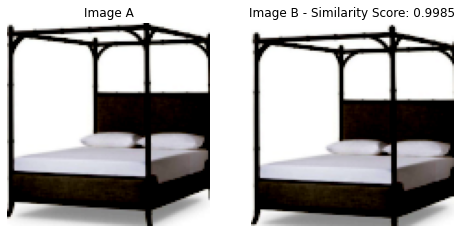

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


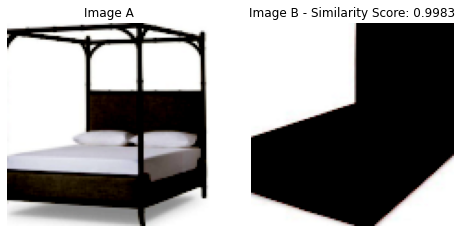

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


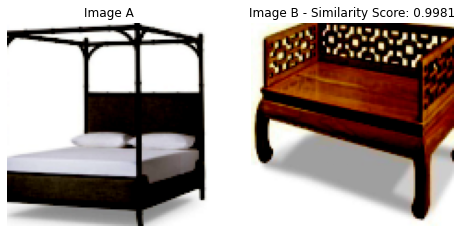

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


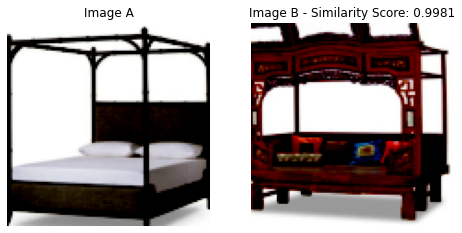

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


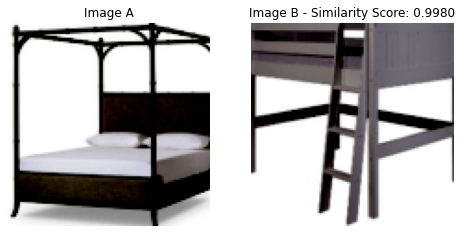

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


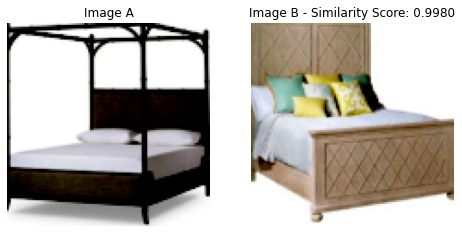

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


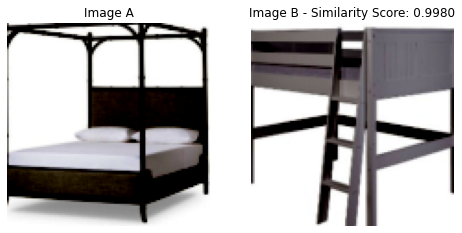

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


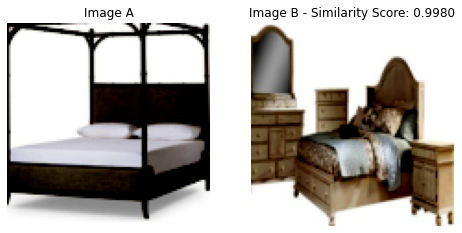

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


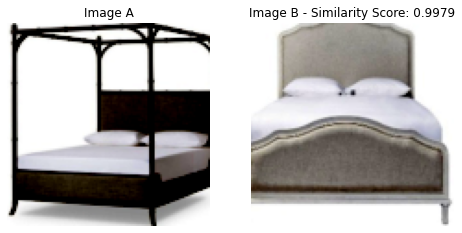

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


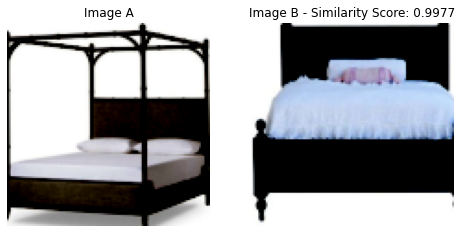

In [63]:
import imagehash

def evaluate_model_with_visualization(model, dataset, transform, device, num_samples=10):
    model.eval()
    similarity_scores = []
    image_pairs = []
    unique_images = set()
    with torch.no_grad():
        for i in range(num_samples):
            # Choose a random sample from the dataset
            sample_idx = np.random.randint(len(dataset))
            image_pair1, label1 = dataset[1]
            image_pair, label = dataset[sample_idx]
            inputA, inputB = image_pair1[0].unsqueeze(0).to(device), image_pair[0].unsqueeze(0).to(device)
            output = model(inputA, inputB)
            
            # Convert tensors to images
            imageA = inputA.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            imageB = inputB.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            
            # Calculate perceptual hashes
            img_hash_A = str(imagehash.phash(Image.fromarray((imageA * 255).astype(np.uint8))))
            img_hash_B = str(imagehash.phash(Image.fromarray((imageB * 255).astype(np.uint8))))
            
            # Check if the images are duplicates
            if img_hash_A not in unique_images and img_hash_B not in unique_images:
                unique_images.add(img_hash_A)
                unique_images.add(img_hash_B)
                similarity_scores.append(output.item())
                image_pairs.append((imageA, imageB))
    
    # Sort the similarity scores and image pairs based on similarity scores
    sorted_indices = np.argsort(similarity_scores)[::-1][:10]
    
    # Display the top 10 image pairs with highest similarity scores
    for idx in sorted_indices:
        imageA, imageB = image_pairs[idx]
        score = similarity_scores[idx]
        
        # Display the images along with the predicted similarity score
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(imageA)
        plt.title('Image A')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(imageB)
        plt.title(f'Image B - Similarity Score: {score:.4f}')
        plt.axis('off')

        plt.show()

# Evaluate the trained model with visualization
evaluate_model_with_visualization(model, pair_dataset, transform, DEVICE, num_samples=10000)


In [47]:
# Save the model and optimizer state
torch.save(model.state_dict(), 'Siamese_(VGG16).pth')
torch.save(optimizer.state_dict(), 'Optimizer_(with_VGG16).pth')

print("Model and optimizer state saved.")

Model and optimizer state saved.


In [46]:
import pickle

# Save the transformation pipeline
with open('Transform.pkl', 'wb') as f:
    pickle.dump(transform, f)

print("Transformation pipeline saved.")

Transformation pipeline saved.
